### Detection of fraudulent transactions in a credit card dataset.

##### Import Libraries

In [1]:
import shap
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import mlflow.sklearn
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from lime.lime_tabular import LimeTabularExplainer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

c:\Users\elbet\miniconda3\envs\elbetel\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mlflow.sklearn.autolog()

##### Load data

In [3]:
df = pd.read_csv('C:/Users/elbet/OneDrive/Desktop/Ten/week8&9/github/Fraud_detection/cleaned_data/Preprocessed_Creditcard_Data.csv')
df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V23       V24       V25       V26       V27  \
0  0.098698  0.363787  ... -0.110474  0.066928  0.128539 -0.189115  0.133558   
1  0.085102 -0.255425  ...  0.101288 -0.339846  0.167170  0.125895 -0.008983   
2  0.247676 -1.514654  ...  0.909412 -0.689281 -0.327642 -0.139097 -0.055353   
3  0.377436 -1.387024  ... -0.190321 -1.175575  0.647376 -0.221929  0.062723   
4 -0.270533  0.817739  ... -0.137458  0.141267 -0.206010  0.502292  0.219422   

        V28  Amount  Class  time_in_days  Amount_scaled  
0 -0.021053  149.62      0      0.000000       0.244200  
1  0.014724    2.69      0      0.000000      -0.342584  
2 -0.059752  378.66      0      0.000012       1.158900  
3  0.061458  123.50      0      0.000012       0.139886  
4  0.215153   69.99      0      0.000023      -0.073813  

[5 rows x 33 columns]

##### Visual class distribution

Class
0    283253
1       473
Name: count, dtype: int64


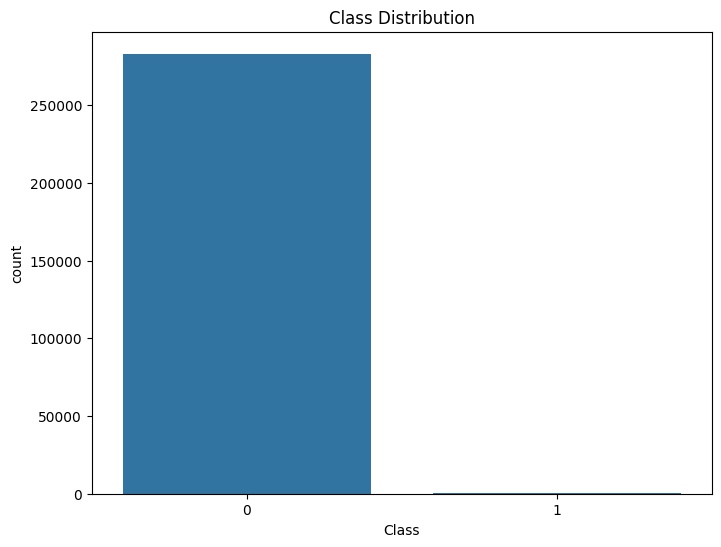

In [4]:
# Visualize Class distribution
class_counts = df['Class'].value_counts()
print(class_counts)

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution')
plt.show()

##### Feature-Target Separation and Data Splitting

In [5]:
X = df.drop('Class', axis=1)
y = df['Class']

##### Using SMOTE (Synthetic Minority Over-sampling Technique) to generate synthetic data

In [7]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train = X_resampled
y_train = y_resampled
class_counts = y_train.value_counts()
print(class_counts)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

2024/10/24 10:51:30 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '247cc7c56caa4243a634f5a85d98b333', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/10/24 10:51:30 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/10/24 10:51:30 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2024/10/24 10:51:30 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/10/24 10:51:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signatu

Class
0    283253
1    283253
Name: count, dtype: int64


##### Scaling the Features

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Tracking with MLflow

In [9]:
import os 
import joblib
# saving the models
save_folder = 'C:/Users/elbet/OneDrive/Desktop/Ten/week8&9/github/Fraud_detection/saved_models'
os.makedirs(save_folder, exist_ok=True) 

# Function to save scikit-learn models
def save_sklearn_model(model, model_name):
    save_path = os.path.join(save_folder, f'{model_name}.joblib')
    joblib.dump(model, save_path)
    print(f'{model_name} saved at {save_path}')


In [10]:
# Function to log experiments with MLflow
def log_experiment(model_name, model, X_train, X_test, y_train, y_test, params=None):
    with mlflow.start_run(run_name=model_name):
        # Fit the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Log parameters if provided
        if params:
            for key, value in params.items():
                mlflow.log_param(key, value)
        
        # Log metrics
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        
        # Log the model
        mlflow.sklearn.log_model(model, model_name)
        
        print(f"Model: {model_name}")
        print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
        save_sklearn_model(model, model_name)
        print('model saved')

##### Training a Logistic Regression Model

In [11]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_experiment("Logistic Regression", log_reg, X_train, X_test, y_train, y_test, 
               params={"max_iter": 1000})

2024/10/24 10:51:57 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2024/10/24 10:52:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: Logistic Regression
Accuracy: 0.9790294963901784, Precision: 0.9906311370556546, Recall: 0.9673463642921234, F1 Score: 0.9788502964163003
Logistic Regression saved at C:/Users/elbet/OneDrive/Desktop/Ten/week8&9/github/Fraud_detection/saved_models\Logistic Regression.joblib
model saved


##### Training a Random forest model

In [12]:
# Random Forest
rand_forest = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
log_experiment("Random Forest", rand_forest, X_train, X_test, y_train, y_test, 
               params={"n_estimators": 100, "max_depth": 10})


2024/10/24 10:52:25 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2024/10/24 10:58:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: Random Forest
Accuracy: 0.9915623731266879, Precision: 0.9987327086122267, Recall: 0.984429704956104, F1 Score: 0.9915296285795293
Random Forest saved at C:/Users/elbet/OneDrive/Desktop/Ten/week8&9/github/Fraud_detection/saved_models\Random Forest.joblib
model saved


##### Training a Gradient Boosting Model

In [13]:
# Gradient Boosting
grad_boost = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
log_experiment("Gradient Boosting", grad_boost, X_train, X_test, y_train, y_test, 
               params={"n_estimators": 100, "learning_rate": 0.1})

2024/10/24 10:59:35 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2024/10/24 11:11:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: Gradient Boosting
Accuracy: 0.9863550511023635, Precision: 0.9937492186523316, Recall: 0.9789581097485881, F1 Score: 0.9862982132728304
Gradient Boosting saved at C:/Users/elbet/OneDrive/Desktop/Ten/week8&9/github/Fraud_detection/saved_models\Gradient Boosting.joblib
model saved


##### Training a DecisionTree Model

In [14]:
# Decision Tree
dec_tree = DecisionTreeClassifier(max_depth=5, random_state=42)
log_experiment("Decision Tree", dec_tree, X_train, X_test, y_train, y_test, 
               params={"max_depth": 5})

2024/10/24 11:11:14 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2024/10/24 11:11:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: Decision Tree
Accuracy: 0.9685177666766694, Precision: 0.9810720994076001, Recall: 0.9556818381744928, F1 Score: 0.9682105394494105
Decision Tree saved at C:/Users/elbet/OneDrive/Desktop/Ten/week8&9/github/Fraud_detection/saved_models\Decision Tree.joblib
model saved


### Model Explanability using shap

In [60]:
import shap
import mlflow
import joblib
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def log_experiment_with_shap(model_name, model, X_train, X_test, y_train, y_test, params=None):
    with mlflow.start_run(run_name=model_name):
        
        # SHAP Explanation for Logistic Regression using KernelExplainer
        if model_name == "Logistic Regression":
            # Use KernelExplainer for Logistic Regression
            background = shap.sample(X_train, 100)  # Sampling a smaller set for the background
            explainer = shap.KernelExplainer(model.predict, background)
            
            # Subsample the test set to handle large data (optional for memory efficiency)
            X_test_sample = X_test[np.random.choice(X_test.shape[0], 100, replace=False)]

            # Get SHAP values
            shap_values = explainer.shap_values(X_test_sample)
            
            shap.summary_plot(shap_values, X_test_sample, plot_type="bar")

        elif model_name in ["Gradient Boosting", "Random Forest", "Decision Tree"]:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test)          
            shap.summary_plot(shap_values, X_test, max_display=32)

        # Logging metrics
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Log parameters and metrics to MLflow
        if params:
            mlflow.log_params(params)
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", rec)
        mlflow.log_metric("f1_score", f1)
        
        print(f"Model: {model_name} | Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1 Score: {f1:.4f}")

##### Logistic regression

100%|██████████| 100/100 [05:00<00:00,  3.01s/it]


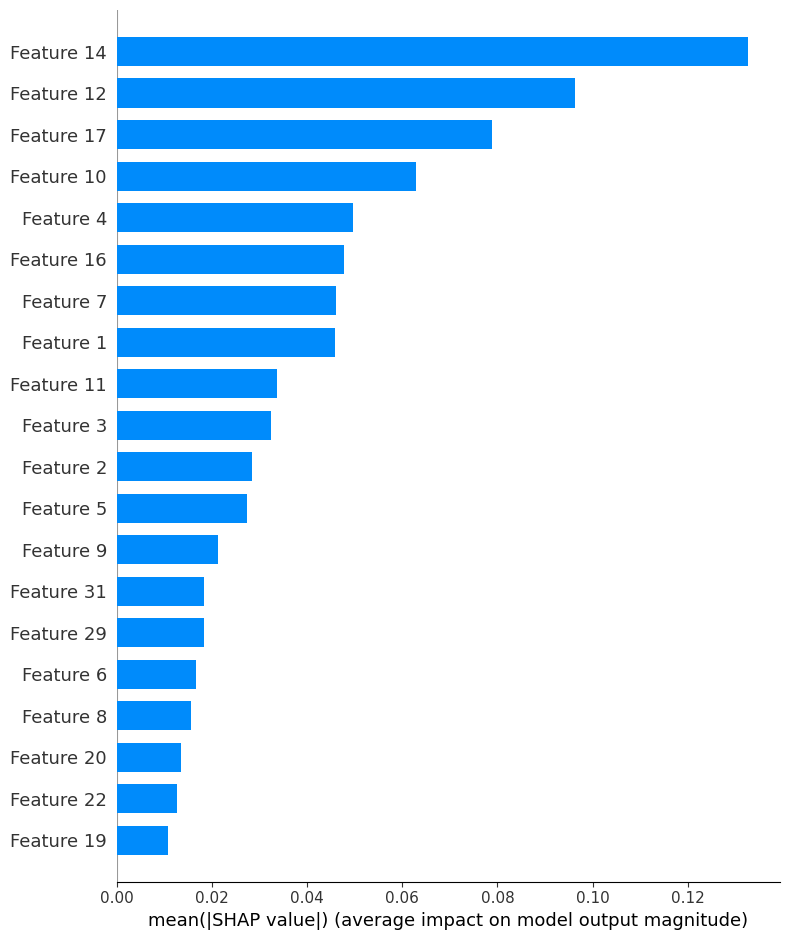

Model: Logistic Regression | Accuracy: 0.9790 | Precision: 0.9906 | Recall: 0.9673 | F1 Score: 0.9789


In [23]:
# Load your saved Logistic Regression model
model = joblib.load('C:/Users/elbet/OneDrive/Desktop/Ten/week8&9/github/Fraud_detection/saved_models/Logistic Regression.joblib')

# Call the function with the loaded model
log_experiment_with_shap("Logistic Regression", model, X_train, X_test, y_train, y_test, params={"max_iter": 100})

##### Decision Tree

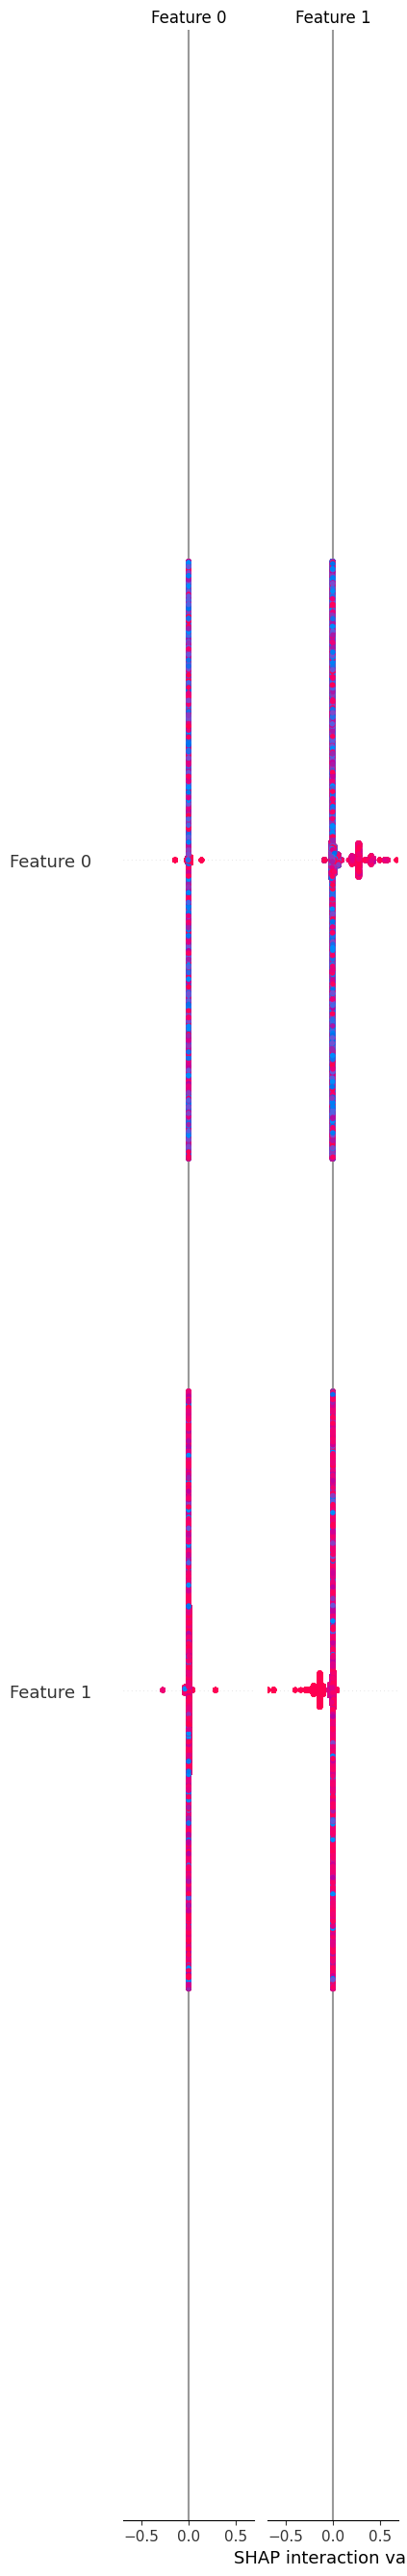

Model: Decision Tree | Accuracy: 0.9685 | Precision: 0.9811 | Recall: 0.9557 | F1 Score: 0.9682


In [61]:

# Load your saved Logistic Regression model
model = joblib.load('C:/Users/elbet/OneDrive/Desktop/Ten/week8&9/github/Fraud_detection/saved_models/Decision Tree.joblib')
log_experiment_with_shap("Decision Tree", model, X_train, X_test, y_train, y_test, 
                         params={"max_depth": 10})


##### RandomForest

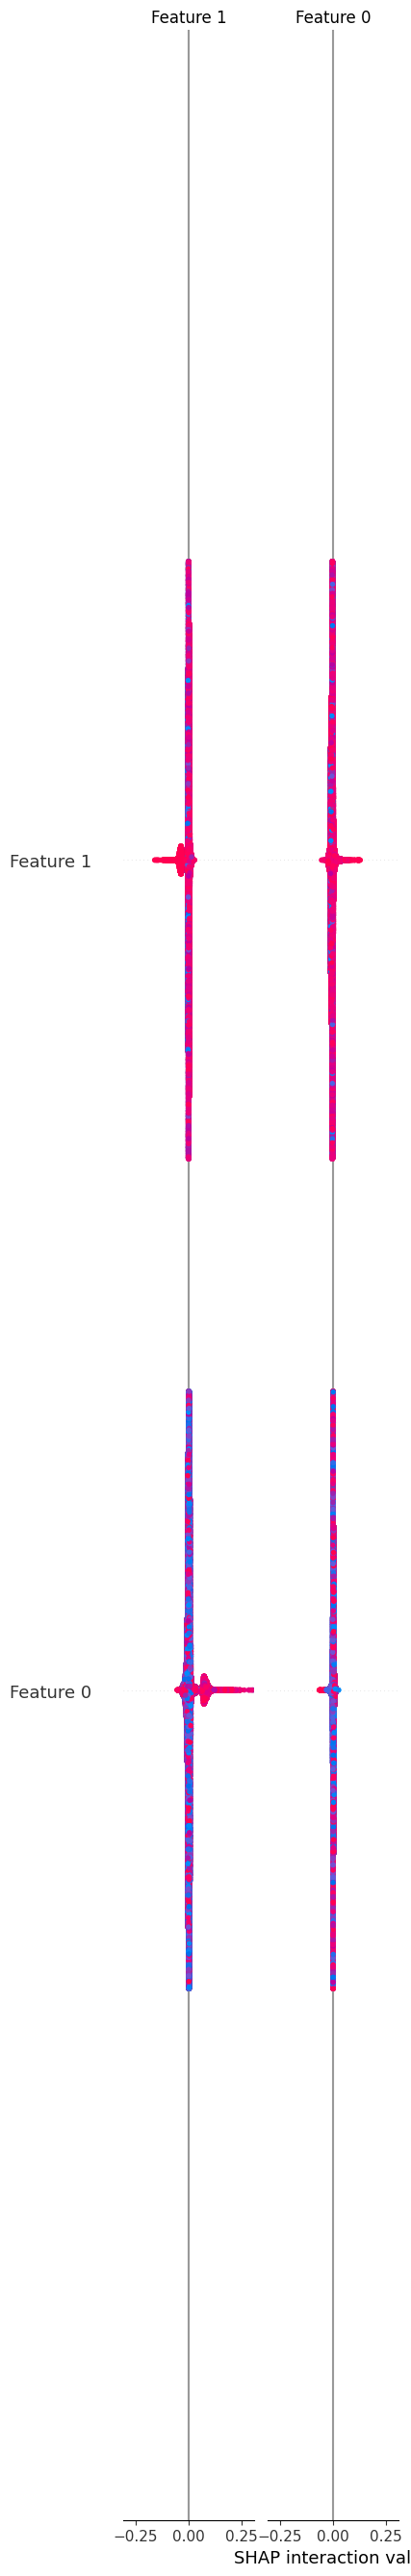

Model: Random Forest | Accuracy: 0.9916 | Precision: 0.9987 | Recall: 0.9844 | F1 Score: 0.9915


In [64]:
# Load your saved Logistic Regression model
model = joblib.load('C:/Users/elbet/OneDrive/Desktop/Ten/week8&9/github/Fraud_detection/saved_models/Random Forest.joblib')
log_experiment_with_shap("Random Forest", model, X_train, X_test, y_train, y_test, 
                         params={"n_estimators": 100})

##### GradientBoosting

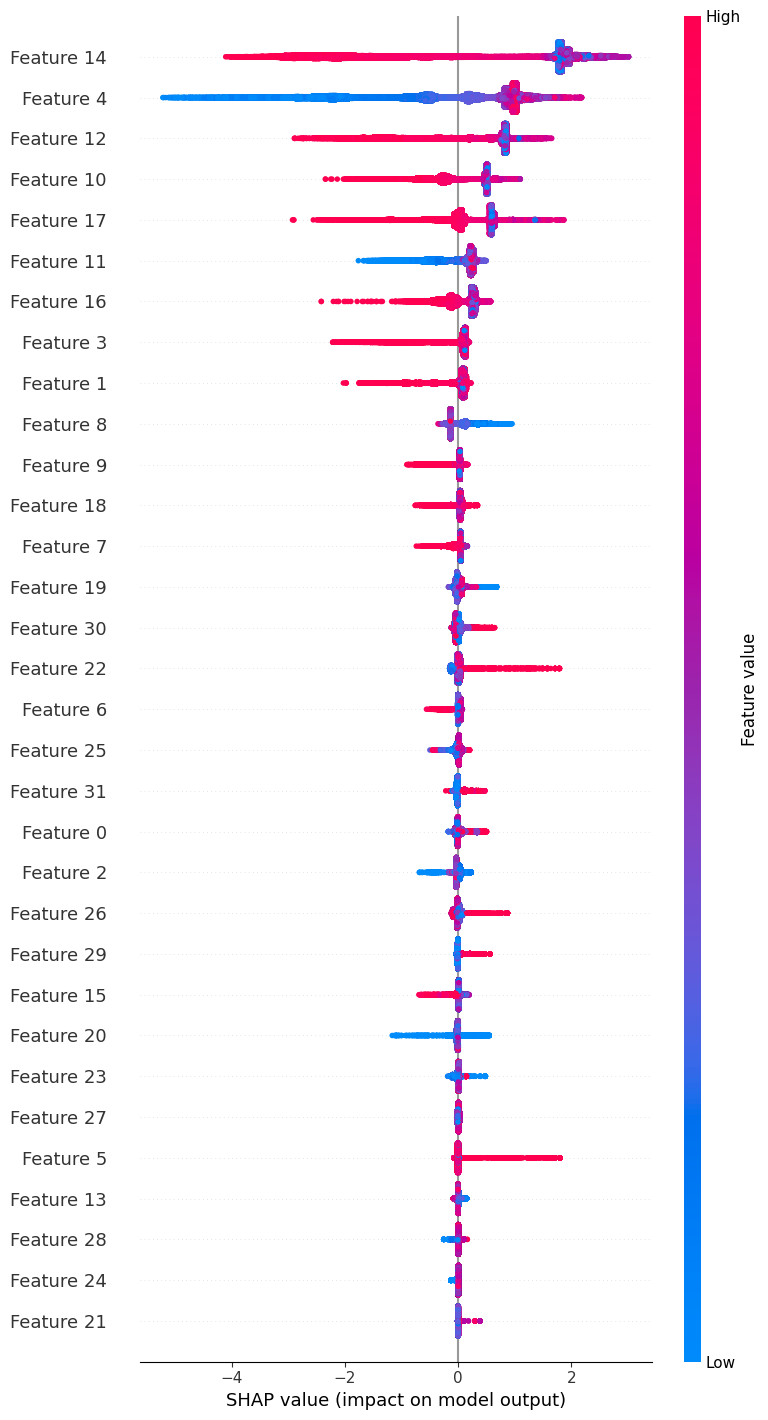

Model: Gradient Boosting | Accuracy: 0.9864 | Precision: 0.9937 | Recall: 0.9790 | F1 Score: 0.9863


In [63]:
# Load your saved Logistic Regression model
model = joblib.load('C:/Users/elbet/OneDrive/Desktop/Ten/week8&9/github/Fraud_detection/saved_models/Gradient Boosting.joblib')
log_experiment_with_shap("Gradient Boosting", model, X_train, X_test, y_train, y_test, 
                         params={"n_estimators": 100, "learning_rate": 0.1})

### Model Explanability using Lime

In [81]:
import mlflow
import mlflow.sklearn
from lime.lime_tabular import LimeTabularExplainer
import joblib
import numpy as np

# Disable autologging for scikit-learn to avoid conflicts
mlflow.sklearn.autolog(disable=True)

def log_experiment_with_lime(model_name, model, X_train, X_test, y_train, y_test, params=None, show_in_notebook=True):
    # Start an MLflow run
    with mlflow.start_run(run_name=model_name):
        
        # Log model parameters if provided and avoid logging None values
        if params is not None:
            params = {k: v for k, v in params.items() if v is not None}  # Remove None values
            mlflow.log_params(params)
        
        # Prepare an input example (first row from X_train)
        input_example = np.array([X_train[0]])
        
        # Log the trained model with an input example
        mlflow.sklearn.log_model(model, model_name, input_example=input_example)
        
        # Fit the model if it hasn't been fitted yet
        if not hasattr(model, 'predict_proba'):
            model.fit(X_train, y_train)
        
        # LIME explanation - Handling numpy arrays
        explainer = LimeTabularExplainer(
            training_data=X_train, 
            mode='classification', 
            feature_names=[f'Feature_{i}' for i in range(X_train.shape[1])],  # Generic feature names if unavailable
            class_names=list(set(y_train)), 
            discretize_continuous=True
        )
        
        # Generate explanation for the first instance in X_test
        exp = explainer.explain_instance(
            X_test[0], 
            model.predict_proba, 
            num_features=5
        )
        
        if show_in_notebook:
            # Show explanation in a Jupyter notebook
            exp.show_in_notebook(show_table=True, show_all=False)
        else:
            # Save explanation as an HTML file for viewing in a browser
            exp.save_to_file("lime_explanation.html")
            print("LIME explanation saved to 'lime_explanation.html'")

        # Print some information
        print(f"Model: {model_name}")


##### Logistic Regression

In [82]:
# Load your saved Logistic Regression model
log_reg = joblib.load('C:/Users/elbet/OneDrive/Desktop/Ten/week8&9/github/Fraud_detection/saved_models/Logistic Regression.joblib')

# Call the function with the Logistic Regression model
log_experiment_with_lime(
    model_name="Logistic Regression", 
    model=log_reg, 
    X_train=X_train, 
    X_test=X_test, 
    y_train=y_train, 
    y_test=y_test, 
    params={"max_iter": 100}
)

Model: Logistic Regression


##### Decision Tree

In [83]:
# Load your saved Logistic Regression model
Decision_Tree = joblib.load('C:/Users/elbet/OneDrive/Desktop/Ten/week8&9/github/Fraud_detection/saved_models/Decision Tree.joblib')

# Call the function with the Logistic Regression model
log_experiment_with_lime(
    model_name="Decision Tree", 
    model=Decision_Tree, 
    X_train=X_train, 
    X_test=X_test, 
    y_train=y_train, 
    y_test=y_test, 
    params={"max_depth": 5}
)

Model: Decision Tree


##### Gradient Boosting

In [84]:
# Load your saved Logistic Regression model
Gradient_Boosting= joblib.load('C:/Users/elbet/OneDrive/Desktop/Ten/week8&9/github/Fraud_detection/saved_models/Gradient Boosting.joblib')

# Call the function with the Logistic Regression model
log_experiment_with_lime(
    model_name="Gradient_Boosting", 
    model=Decision_Tree, 
    X_train=X_train, 
    X_test=X_test, 
    y_train=y_train, 
    y_test=y_test, 
    params={"n_estimators": 100, "learning_rate": 0.1}
)

Model: Gradient_Boosting


##### Random forest

In [85]:
# Load your saved Logistic Regression model
Random_Forest= joblib.load('C:/Users/elbet/OneDrive/Desktop/Ten/week8&9/github/Fraud_detection/saved_models/Random Forest.joblib')

# Call the function with the Logistic Regression model
log_experiment_with_lime(
    model_name="Random_Forest", 
    model=Decision_Tree, 
    X_train=X_train, 
    X_test=X_test, 
    y_train=y_train, 
    y_test=y_test, 
    params={"n_estimators": 100, "max_depth": 10}
)

Model: Random_Forest


In [ ]:
#